In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
import missingno as msno

In [2]:
sa = pd.read_csv('/content/drive/MyDrive/pindah/sumur baru/sa.csv', sep=';')
sb = pd.read_csv('/content/drive/MyDrive/pindah/sumur baru/sb.csv', sep=';')
sc = pd.read_csv('/content/drive/MyDrive/pindah/sumur baru/sc.csv', sep=';')
sd = pd.read_csv('/content/drive/MyDrive/pindah/sumur baru/sd.csv', sep=';')
se = pd.read_csv('/content/drive/MyDrive/pindah/sumur baru/se.csv', sep=';')
sf = pd.read_csv('/content/drive/MyDrive/pindah/sumur baru/sf.csv', sep=';')
sg = pd.read_csv('/content/drive/MyDrive/pindah/sumur baru/sg.csv', sep=';')

In [3]:
sa['well'] = 'a'
sb['well'] = 'b'
sc['well'] = 'c'
sd['well'] = 'd'
se['well'] = 'e'
sf['well'] = 'f'
sg['well'] = 'g'

In [4]:
# load data
train = pd.read_csv('/content/drive/MyDrive/Public geoscience Data/FORCE 2020 lithofacies prediction from well logs competition/CSV_train.csv', sep=';')
hidden_test = pd.read_csv('/content/drive/MyDrive/Public geoscience Data/FORCE 2020 lithofacies prediction from well logs competition/CSV_hidden_test.csv', sep=';')
test = pd.read_csv('/content/drive/MyDrive/Public geoscience Data/FORCE 2020 lithofacies prediction from well logs competition/CSV_test.csv', sep=';')

data = pd.concat([test, train, hidden_test], axis=0).drop(['FORMATION', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'RSHA', 'CALI', 'RMED', 'SGR',
                                     'PEF', 'SP', 'BS', 'ROP', 'DTS', 'DCAL', 'DRHO', 'MUDWEIGHT', 'RMIC', 'ROPA',
                                     'RXO', 'RDEP', 'DTC', 'FORCE_2020_LITHOFACIES_CONFIDENCE'], axis=1).dropna(subset=['RHOB', 'GR', 'NPHI'])

simple_lithology_numbers = {30000: 0,
             65030: 1,
             65000: 2,
             80000: 3,
             74000: 4,
             70000: 5,
             70032: 6,
             88000: 7,
             86000: 8,
             99000: 9,
             90000: 10,
             93000: 11}

data['LITH'] = data['FORCE_2020_LITHOFACIES_LITHOLOGY'].map(simple_lithology_numbers)
data = data.drop(['FORCE_2020_LITHOFACIES_LITHOLOGY'], axis=1)

sample = data.sample(frac=0.05, replace=True, random_state=42)

# removing outlier
## sample
cv = [sample.GR.quantile(0.995) if i >= sample.GR.quantile(0.995) else sample.GR.quantile(0.005)
    if i <= sample.GR.quantile(0.005) else i for i in sample.GR]
cv2 = [sample.NPHI.quantile(0.995) if i >= sample.NPHI.quantile(0.995) else sample.NPHI.quantile(0.005)
    if i <= sample.NPHI.quantile(0.005) else i for i in sample.NPHI]
cv3 = [sample.RHOB.quantile(0.995) if i >= sample.RHOB.quantile(0.995) else sample.RHOB.quantile(0.005)
    if i <= sample.RHOB.quantile(0.005) else i for i in sample.RHOB]

sample_new = sample.copy()
sample_new['GR'] = cv
sample_new['NPHI'] = cv2
sample_new['RHOB'] = cv3

# scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

sample_X = pd.DataFrame(scaler.fit_transform(sample_new.drop(['WELL', 'DEPTH_MD', 'LITH'], axis=1)),
                        columns=['RHOB', 'GR', 'NPHI']).dropna()

In [5]:
# clustering
from tqdm.auto import tqdm
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [6]:
## k=5
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(sample_X)

sample_pred = sample.copy()
sample_pred['cluster'] = kmeans.predict(sample_X)

In [7]:
# visualization
facies_color_map = { 0: '#F4D03F',
                     1: '#7ccc19',
                     2: '#196F3D',
                     3: '#160599',
                     4: '#2756c4',
                     5: '#3891f0',
                     6: '#80d4ff',
                     7: '#87039e',
                     8: '#ec90fc',
                     9: '#FF4500',
                     10: '#000000',
                     11: '#DC7633'}

facies_colors_facies = [facies_color_map[mykey] for mykey in facies_color_map.keys()]

facies_colors_clust = ['#7ccc19', '#2756c4', '#ec90fc', '#FF4500', '#DC7633']

def compare_facies_plot(logs, compadre, facies_colors_facies, facies_colors_clust):
    #make sure logs are sorted by depth
    logs = logs.sort_values(by='DEPTH_MD')
    cmap_facies_facies = colors.ListedColormap(
            facies_colors_facies[0:len(facies_colors_facies)], 'indexed')
    cmap_facies_clust = colors.ListedColormap(
            facies_colors_clust[0:len(facies_colors_clust)], 'indexed')
    
    ztop=logs.DEPTH_MD.min(); zbot=logs.DEPTH_MD.max()
    
    cluster1 = np.repeat(np.expand_dims(logs['LF'].values,1), 100, 1)
    cluster2 = np.repeat(np.expand_dims(logs[compadre].values,1), 100, 1)
    
    f, ax = plt.subplots(nrows=1, ncols=5, figsize=(9, 12))
    ax[0].plot(logs.GR, logs.DEPTH_MD, '-g')
    ax[1].plot(logs.RHOB, logs.DEPTH_MD, '-', color='r')
    ax[2].plot(logs.NPHI, logs.DEPTH_MD, '-', color='black')
    im1 = ax[3].imshow(cluster1, interpolation='none', aspect='auto',
                    cmap=cmap_facies_facies,vmin=0,vmax=11)
    im2 = ax[4].imshow(cluster2, interpolation='none', aspect='auto',
                    cmap=cmap_facies_clust,vmin=0,vmax=4)
    
    divider = make_axes_locatable(ax[4])
    cax = divider.append_axes("right", size="20%", pad=0.05)
    cbar=plt.colorbar(im2, cax=cax)
    cbar.set_label((40*' ').join(['0', '1', '2', '3', '4']))
    cbar.set_ticks(range(0,1)); cbar.set_ticklabels('')
    
    for i in range(len(ax)-2):
        ax[i].set_ylim(ztop,zbot)
        ax[i].invert_yaxis()
        ax[i].grid()
        ax[i].locator_params(axis='x', nbins=3)
    
    ax[0].set_xlabel("GR")
    ax[0].set_xlim(0, 150)
    ax[1].set_xlabel("RHOB")
    ax[1].set_xlim(1.5, 3)
    ax[2].set_xlabel("NPHI")
    ax[2].set_xlim(0, 1)
    ax[3].set_xlabel('lithofacies')
    ax[4].set_xlabel(compadre)
    
    ax[1].set_yticklabels([]); ax[2].set_yticklabels([]); ax[3].set_yticklabels([])
    ax[3].set_xticklabels([]); ax[4].set_yticklabels([])
    ax[4].set_xticklabels([])
    f.suptitle('sumur %s'%logs.iloc[0]['well'], fontsize=14,y=0.9)
    f.savefig('sumur %s.png'%logs.iloc[0]['well'])

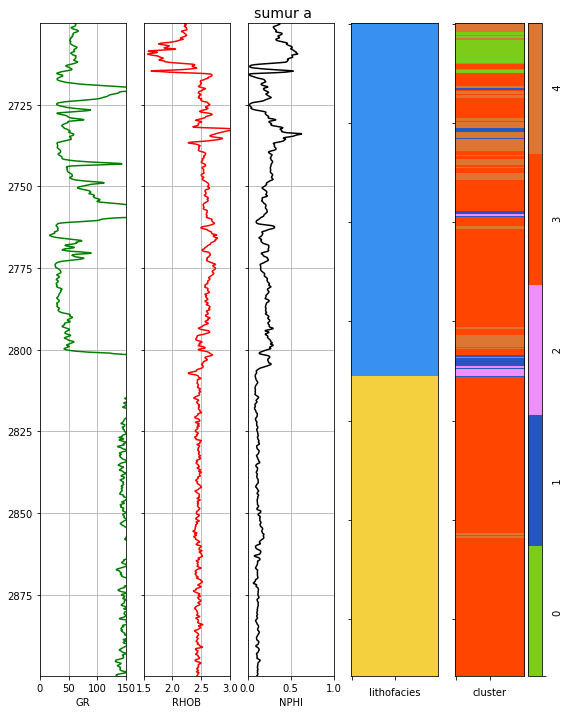

In [8]:
cva = [sa.GR.quantile(0.995) if i >= sa.GR.quantile(0.995) else sa.GR.quantile(0.005)
    if i <= sa.GR.quantile(0.005) else i for i in sa.GR]
cv2a = [sa.NPHI.quantile(0.995) if i >= sa.NPHI.quantile(0.995) else sa.NPHI.quantile(0.005)
    if i <= sa.NPHI.quantile(0.005) else i for i in sa.NPHI]
cv3a = [sa.RHOB.quantile(0.995) if i >= sa.RHOB.quantile(0.995) else sa.RHOB.quantile(0.005)
    if i <= sa.RHOB.quantile(0.005) else i for i in sa.RHOB]

sa_new = sa.copy()
sa_new['GR'] = cva
sa_new['NPHI'] = cv2a
sa_new['RHOB'] = cv3a

sa_X = pd.DataFrame(scaler.fit_transform(sa_new.drop(['WELL', 'DEPTH_MD', 'DEPTH_MD.1', 'LITH', 'FORMATION', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'RSHA', 'CALI', 'RMED', 'SGR',
                                     'PEF', 'SP', 'BS', 'ROP', 'DTS', 'DCAL', 'DRHO', 'MUDWEIGHT', 'RMIC', 'ROPA',
                                     'RXO', 'RDEP', 'DTC', 'FORCE_2020_LITHOFACIES_CONFIDENCE', 'LF', 'well', 'FACIES'], axis=1)),
                        columns=['RHOB', 'GR', 'NPHI']).dropna()

sa_pred = sa.copy()
sa_pred['cluster'] = kmeans.predict(sa_X)

compare_facies_plot(sa_pred, 'cluster', facies_colors_facies, facies_colors_clust)

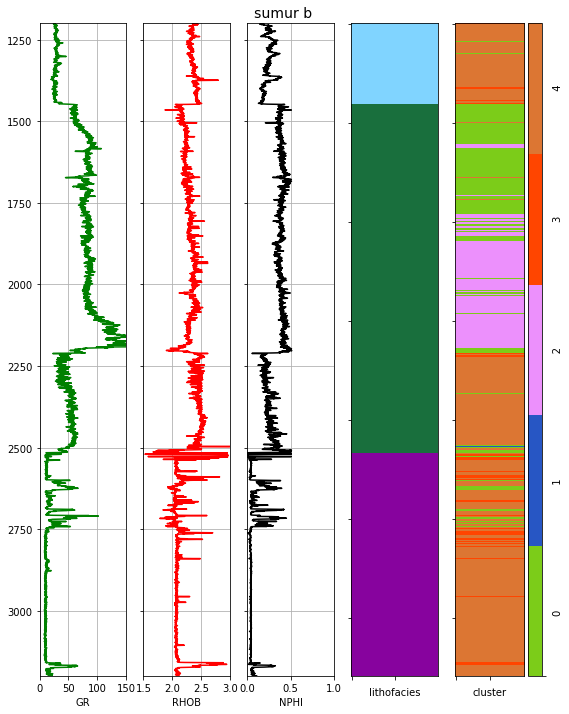

In [9]:
cvb = [sb.GR.quantile(0.995) if i >= sb.GR.quantile(0.995) else sb.GR.quantile(0.005)
    if i <= sb.GR.quantile(0.005) else i for i in sb.GR]
cv2b = [sa.NPHI.quantile(0.995) if i >= sb.NPHI.quantile(0.995) else sb.NPHI.quantile(0.005)
    if i <= sb.NPHI.quantile(0.005) else i for i in sb.NPHI]
cv3b = [sa.RHOB.quantile(0.995) if i >= sb.RHOB.quantile(0.995) else sb.RHOB.quantile(0.005)
    if i <= sb.RHOB.quantile(0.005) else i for i in sb.RHOB]

sb_new = sb.copy()
sb_new['GR'] = cvb
sb_new['NPHI'] = cv2b
sb_new['RHOB'] = cv3b

sb_X = pd.DataFrame(scaler.fit_transform(sb_new.drop(['WELL', 'DEPTH_MD', 'DEPTH_MD.1', 'LITH', 'FORMATION', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'RSHA', 'CALI', 'RMED', 'SGR',
                                     'PEF', 'SP', 'BS', 'ROP', 'DTS', 'DCAL', 'DRHO', 'MUDWEIGHT', 'RMIC', 'ROPA',
                                     'RXO', 'RDEP', 'DTC', 'FORCE_2020_LITHOFACIES_CONFIDENCE', 'LF', 'well', 'FACIES'], axis=1)),
                        columns=['RHOB', 'GR', 'NPHI']).dropna()

sb_pred = sb.copy()
sb_pred['cluster'] = kmeans.predict(sb_X)

compare_facies_plot(sb_pred, 'cluster', facies_colors_facies, facies_colors_clust)

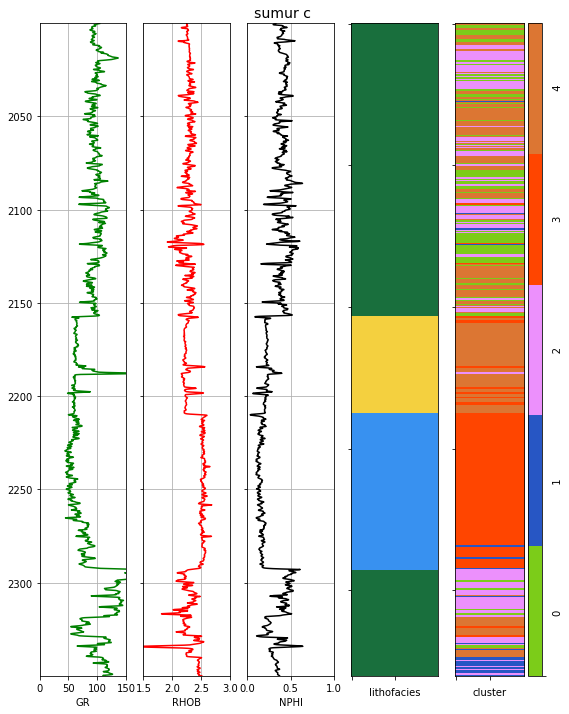

In [10]:
cvc = [sc.GR.quantile(0.995) if i >= sc.GR.quantile(0.995) else sc.GR.quantile(0.005)
    if i <= sc.GR.quantile(0.005) else i for i in sc.GR]
cv2c = [sc.NPHI.quantile(0.995) if i >= sc.NPHI.quantile(0.995) else sc.NPHI.quantile(0.005)
    if i <= sc.NPHI.quantile(0.005) else i for i in sc.NPHI]
cv3c = [sc.RHOB.quantile(0.995) if i >= sc.RHOB.quantile(0.995) else sc.RHOB.quantile(0.005)
    if i <= sc.RHOB.quantile(0.005) else i for i in sc.RHOB]

sc_new = sc.copy()
sc_new['GR'] = cvc
sc_new['NPHI'] = cv2c
sc_new['RHOB'] = cv3c

sc_X = pd.DataFrame(scaler.fit_transform(sc_new.drop(['WELL', 'DEPTH_MD', 'DEPTH_MD.1', 'LITH', 'FORMATION', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'RSHA', 'CALI', 'RMED', 'SGR',
                                     'PEF', 'SP', 'BS', 'ROP', 'DTS', 'DCAL', 'DRHO', 'MUDWEIGHT', 'RMIC', 'ROPA',
                                     'RXO', 'RDEP', 'DTC', 'FORCE_2020_LITHOFACIES_CONFIDENCE', 'LF', 'well', 'FACIES'], axis=1)),
                        columns=['RHOB', 'GR', 'NPHI']).dropna()

sc_pred = sc.copy()
sc_pred['cluster'] = kmeans.predict(sc_X)

compare_facies_plot(sc_pred, 'cluster', facies_colors_facies, facies_colors_clust)

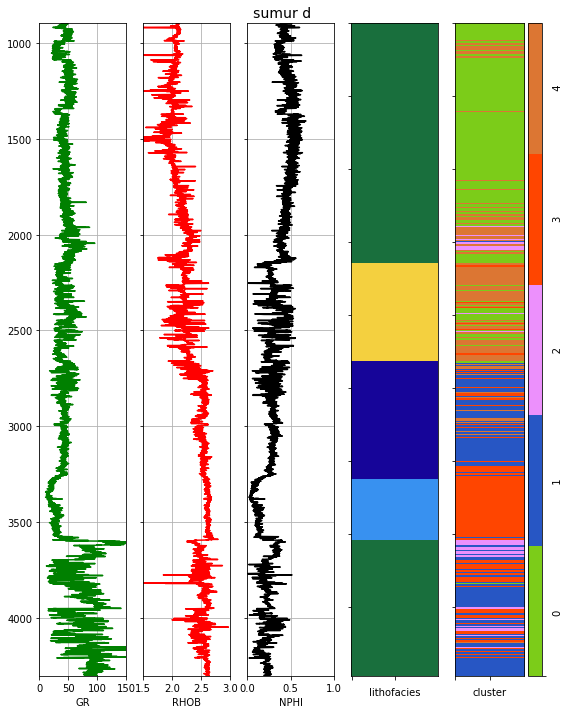

In [11]:
cvd = [sd.GR.quantile(0.995) if i >= sd.GR.quantile(0.995) else sd.GR.quantile(0.005)
    if i <= sd.GR.quantile(0.005) else i for i in sd.GR]
cv2d = [sd.NPHI.quantile(0.995) if i >= sd.NPHI.quantile(0.995) else sd.NPHI.quantile(0.005)
    if i <= sd.NPHI.quantile(0.005) else i for i in sd.NPHI]
cv3d = [sd.RHOB.quantile(0.995) if i >= sd.RHOB.quantile(0.995) else sd.RHOB.quantile(0.005)
    if i <= sd.RHOB.quantile(0.005) else i for i in sd.RHOB]

sd_new = sd.copy()
sd_new['GR'] = cvd
sd_new['NPHI'] = cv2d
sd_new['RHOB'] = cv3d

sd_X = pd.DataFrame(scaler.fit_transform(sd_new.drop(['WELL', 'DEPTH_MD', 'DEPTH_MD.1', 'LITH', 'FORMATION', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'RSHA', 'CALI', 'RMED', 'SGR',
                                     'PEF', 'SP', 'BS', 'ROP', 'DTS', 'DCAL', 'DRHO', 'MUDWEIGHT', 'RMIC', 'ROPA',
                                     'RXO', 'RDEP', 'DTC', 'FORCE_2020_LITHOFACIES_CONFIDENCE', 'LF', 'well', 'FACIES'], axis=1)),
                        columns=['RHOB', 'GR', 'NPHI']).dropna()

sd_pred = sd.copy()
sd_pred['cluster'] = kmeans.predict(sd_X)

compare_facies_plot(sd_pred, 'cluster', facies_colors_facies, facies_colors_clust)

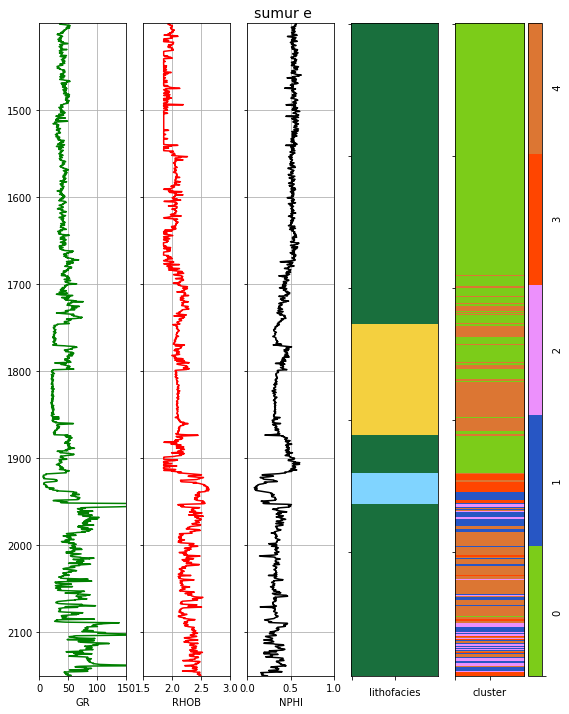

In [12]:
cve = [se.GR.quantile(0.995) if i >= se.GR.quantile(0.995) else se.GR.quantile(0.005)
    if i <= se.GR.quantile(0.005) else i for i in se.GR]
cv2e = [se.NPHI.quantile(0.995) if i >= se.NPHI.quantile(0.995) else se.NPHI.quantile(0.005)
    if i <= se.NPHI.quantile(0.005) else i for i in se.NPHI]
cv3e = [se.RHOB.quantile(0.995) if i >= se.RHOB.quantile(0.995) else se.RHOB.quantile(0.005)
    if i <= se.RHOB.quantile(0.005) else i for i in se.RHOB]

se_new = se.copy()
se_new['GR'] = cve
se_new['NPHI'] = cv2e
se_new['RHOB'] = cv3e

se_X = pd.DataFrame(scaler.fit_transform(se_new.drop(['WELL', 'DEPTH_MD', 'DEPTH_MD.1', 'LITH', 'FORMATION', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'RSHA', 'CALI', 'RMED', 'SGR',
                                     'PEF', 'SP', 'BS', 'ROP', 'DTS', 'DCAL', 'DRHO', 'MUDWEIGHT', 'RMIC', 'ROPA',
                                     'RXO', 'RDEP', 'DTC', 'FORCE_2020_LITHOFACIES_CONFIDENCE', 'LF', 'well', 'FACIES'], axis=1)),
                        columns=['RHOB', 'GR', 'NPHI']).dropna()

se_pred = se.copy()
se_pred['cluster'] = kmeans.predict(se_X)

compare_facies_plot(se_pred, 'cluster', facies_colors_facies, facies_colors_clust)

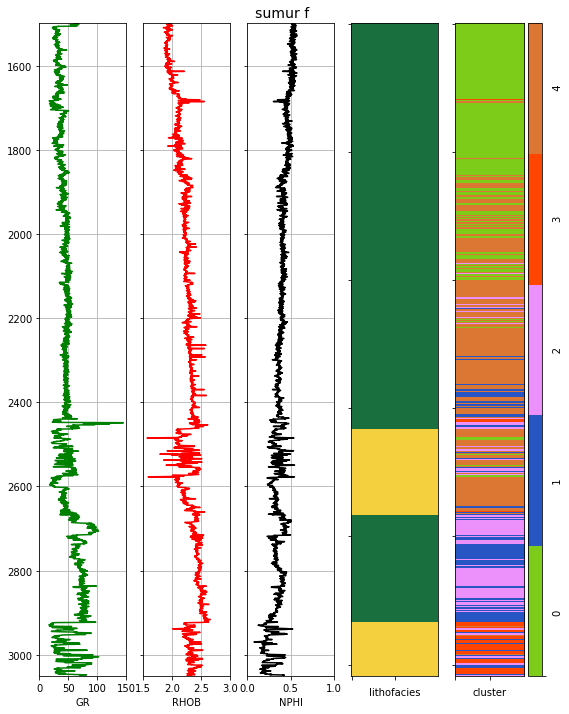

In [13]:
cvf = [sf.GR.quantile(0.995) if i >= sf.GR.quantile(0.995) else sf.GR.quantile(0.005)
    if i <= sf.GR.quantile(0.005) else i for i in sf.GR]
cv2f = [sf.NPHI.quantile(0.995) if i >= sf.NPHI.quantile(0.995) else sf.NPHI.quantile(0.005)
    if i <= sf.NPHI.quantile(0.005) else i for i in sf.NPHI]
cv3f = [sf.RHOB.quantile(0.995) if i >= sf.RHOB.quantile(0.995) else sf.RHOB.quantile(0.005)
    if i <= sf.RHOB.quantile(0.005) else i for i in sf.RHOB]

sf_new = sf.copy()
sf_new['GR'] = cvf
sf_new['NPHI'] = cv2f
sf_new['RHOB'] = cv3f

sf_X = pd.DataFrame(scaler.fit_transform(sf_new.drop(['WELL', 'DEPTH_MD', 'DEPTH_MD.1', 'LITH', 'FORMATION', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'RSHA', 'CALI', 'RMED', 'SGR',
                                     'PEF', 'SP', 'BS', 'ROP', 'DTS', 'DCAL', 'DRHO', 'MUDWEIGHT', 'RMIC', 'ROPA',
                                     'RXO', 'RDEP', 'DTC', 'FORCE_2020_LITHOFACIES_CONFIDENCE', 'LF', 'well', 'FACIES'], axis=1)),
                        columns=['RHOB', 'GR', 'NPHI']).dropna()

sf_pred = sf.copy()
sf_pred['cluster'] = kmeans.predict(sf_X)

compare_facies_plot(sf_pred, 'cluster', facies_colors_facies, facies_colors_clust)

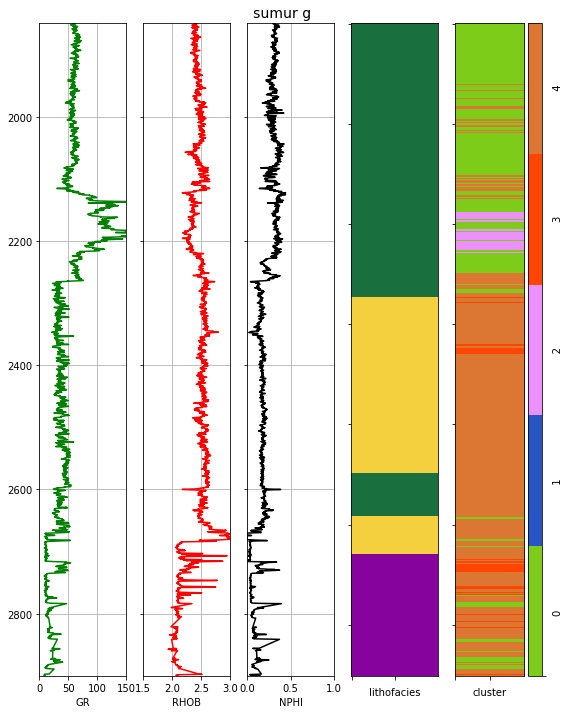

In [14]:
cvg = [sg.GR.quantile(0.995) if i >= sg.GR.quantile(0.995) else sg.GR.quantile(0.005)
    if i <= sg.GR.quantile(0.005) else i for i in sg.GR]
cv2g = [sg.NPHI.quantile(0.995) if i >= sg.NPHI.quantile(0.995) else sg.NPHI.quantile(0.005)
    if i <= sg.NPHI.quantile(0.005) else i for i in sg.NPHI]
cv3g = [sg.RHOB.quantile(0.995) if i >= sg.RHOB.quantile(0.995) else sg.RHOB.quantile(0.005)
    if i <= sg.RHOB.quantile(0.005) else i for i in sg.RHOB]

sg_new = sg.copy()
sg_new['GR'] = cvg
sg_new['NPHI'] = cv2g
sg_new['RHOB'] = cv3g

sg_X = pd.DataFrame(scaler.fit_transform(sg_new.drop(['WELL', 'DEPTH_MD', 'DEPTH_MD.1', 'LITH', 'FORMATION', 'X_LOC', 'Y_LOC', 'Z_LOC', 'GROUP', 'RSHA', 'CALI', 'RMED', 'SGR',
                                     'PEF', 'SP', 'BS', 'ROP', 'DTS', 'DCAL', 'DRHO', 'MUDWEIGHT', 'RMIC', 'ROPA',
                                     'RXO', 'RDEP', 'DTC', 'FORCE_2020_LITHOFACIES_CONFIDENCE', 'LF', 'well', 'FACIES'], axis=1)),
                        columns=['RHOB', 'GR', 'NPHI']).dropna()

sg_pred = sg.copy()
sg_pred['cluster'] = kmeans.predict(sg_X)

compare_facies_plot(sg_pred, 'cluster', facies_colors_facies, facies_colors_clust)

In [15]:
import seaborn as sns

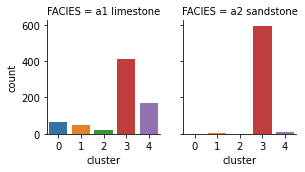

In [16]:
sns.catplot(x="cluster", col="FACIES", col_wrap=5,
            data=sa_pred,
            kind="count", height=2.5, aspect=.8)

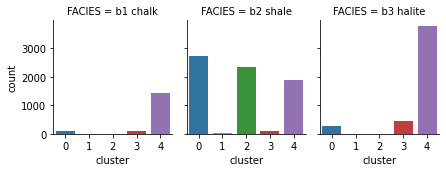

In [17]:
sns.catplot(x="cluster", col="FACIES", col_wrap=5,
            data=sb_pred,
            kind="count", height=2.5, aspect=.8)

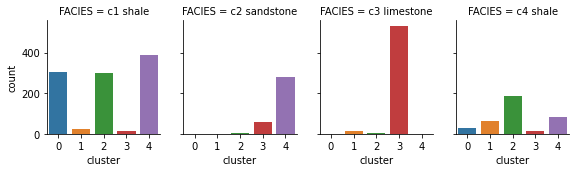

In [18]:
sns.catplot(x="cluster", col="FACIES", col_wrap=5,
            data=sc_pred,
            kind="count", height=2.5, aspect=.8)

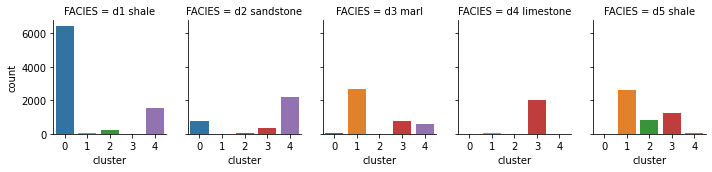

In [19]:
sns.catplot(x="cluster", col="FACIES", col_wrap=5,
            data=sd_pred,
            kind="count", height=2.5, aspect=.8)

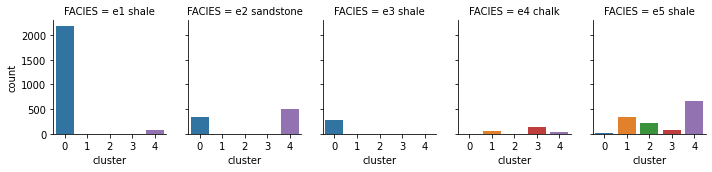

In [20]:
sns.catplot(x="cluster", col="FACIES", col_wrap=5,
            data=se_pred,
            kind="count", height=2.5, aspect=.8)

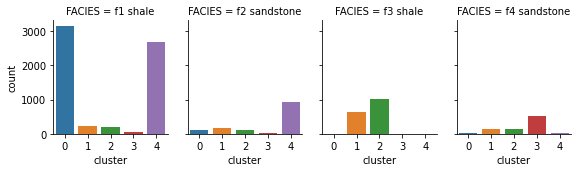

In [21]:
sns.catplot(x="cluster", col="FACIES", col_wrap=5,
            data=sf_pred,
            kind="count", height=2.5, aspect=.8)

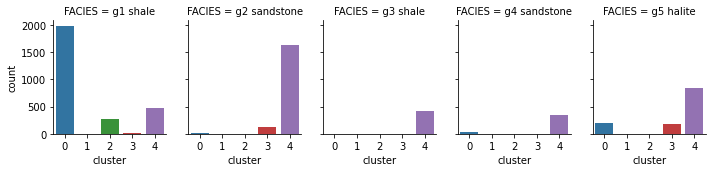

In [22]:
sns.catplot(x="cluster", col="FACIES", col_wrap=5,
            data=sg_pred,
            kind="count", height=2.5, aspect=.8)

In [23]:
sall_pred = pd.concat([sa_pred, sb_pred, sc_pred, sd_pred, se_pred, sf_pred, sg_pred])

In [24]:
sa_pred.to_excel('sa_pred.xlsx')
sb_pred.to_excel('sb_pred.xlsx')
sc_pred.to_excel('sc_pred.xlsx')
sd_pred.to_excel('sd_pred.xlsx')
se_pred.to_excel('se_pred.xlsx')
sf_pred.to_excel('sf_pred.xlsx')
sg_pred.to_excel('sg_pred.xlsx')